# AUTHOR
***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-05-13**

# SUMMARY

- Lagrangian: $~~\mathcal{L}(\mathbf{w}, b, \xi, \lambda, \mu) = \frac{1}{2}{||\mathbf{w}||_2^2} + C \sum_{n=1}^N \xi_n + \sum_{n=1}^N \lambda_n ( 1 - \xi_n - y_n(\mathbf{w}^T\mathbf{x}_n + b)) - \sum_{n=1}^N \mu_n \xi_n ~$

- Lagrangian dual function: $~~g(\lambda, \mu) = \min_{\mathbf{w}, b, \xi} \mathcal{L}(\mathbf{w}, b, \xi, \lambda, \mu) $
$= g(\lambda, \mu) = \sum_{n=1}^N \lambda_n - \frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N \lambda_n \lambda_m y_n y_m \mathbf{x}_n^T\mathbf{x}_m$
- We have to find minimum of Lagrangian: $\min\mathcal{L}(\mathbf{w}, b, \xi, \lambda, \mu))$
- or find maximum of Lagrangian dual function:
$g(\lambda)$


# import modules and generate data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from scipy.spatial.distance import cdist
from math import sqrt
from copy import deepcopy
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
means = [[2, 2], [4, 2]]
cov = [[.4, .1], [.1, .4]]
N = 40
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N) 
X = np.concatenate((X0.T, X1.T), axis = 1) # dim = [2, 2 * N]
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1) # dim = [1, 2 * N]

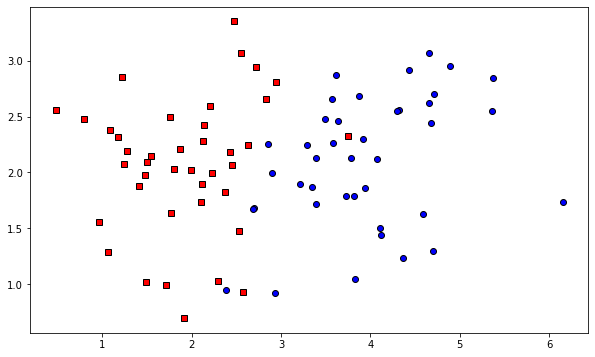

In [3]:
def plot_data(X, y):
  plt.figure(figsize=(10, 6))

  X_1 = X[:, (y == 1)[0]]

  X_2 = X[:, (y == -1)[0]]
  plt.plot(X_1[0], X_1[1], "rs", markeredgecolor = 'k')
  plt.plot(X_2[0], X_2[1], "bo", markeredgecolor = 'k')

  plt.show()

plot_data(X, y)

In [4]:
def getIntercept(w1, w2, b, a, x_axis, y_axis):
  xo_inf = (a - b - w2 * y_axis[0]) / w1
  xo_sup = (a - b - w2 * y_axis[1]) / w1
  yo_inf = (a - b - w1 * x_axis[0]) / w2
  yo_sup = (a - b - w1 * x_axis[1]) / w2
  ls = [(x_axis[0], yo_inf),
        (x_axis[1], yo_sup), 
        (xo_inf, y_axis[0]),
        (xo_sup, y_axis[1])]

  ls.sort()
  return [ls[1][0], ls[2][0]], [ls[1][1], ls[2][1]]


def visualize(w, b, X, y, x_axis, y_axis, n_ = 200, level_sets= 200, dpi= 100, support_vectors=[]):
  plt.figure(dpi=dpi)
  x_ = np.linspace(x_axis[0], x_axis[1], n_)
  y_ = np.linspace(y_axis[0], y_axis[1], n_)
  l = len(x_)

  x_, y_ = np.meshgrid(x_, y_)
  xx = x_.reshape(-1)
  yy = y_.reshape(-1)
  x = np.vstack((xx, yy))
  z = np.sign(w.T @ x + b)
  z = z.reshape(l, l)

  plt.contourf(x_, y_, z, level_sets, cmap='jet', alpha = .3)

  if len(support_vectors) > 0:
    vecs = X[:, support_vectors]
    plt.scatter(vecs[0] , vecs[1] , s=100 ,  facecolors='none', edgecolors='black' ) 

  X_1 = X[:, (y == 1)[0]]
  X_2 = X[:, (y == -1)[0]]
  plt.plot(X_1[0], X_1[1], "rs", markeredgecolor = 'k')
  plt.plot(X_2[0], X_2[1], "bo", markeredgecolor = 'k')

  w1 = w[0, 0]
  w2 = w[1, 0]

  lim_pos = getIntercept(w1, w2, b, 1, x_axis, y_axis)
  lim_neg = getIntercept(w1, w2, b, -1, x_axis, y_axis)
  lim_ = getIntercept(w1, w2, b, 0, x_axis, y_axis)

  plt.plot(lim_pos[0], lim_pos[1], 'b')
  plt.plot(lim_neg[0], lim_neg[1], 'b')
  plt.plot(lim_[0], lim_[1], 'k', linewidth=3)

  plt.show()

## Soft margin SVM using CVXOPT

- Lagrangian: $~~\mathcal{L}(\mathbf{w}, b, \xi, \lambda, \mu) = \frac{1}{2}{||\mathbf{w}||_2^2} + C \sum_{n=1}^N \xi_n + \sum_{n=1}^N \lambda_n ( 1 - \xi_n - y_n(\mathbf{w}^T\mathbf{x}_n + b)) - \sum_{n=1}^N \mu_n \xi_n ~$

- Lagrangian dual function: $~~g(\lambda, \mu) = \min_{\mathbf{w}, b, \xi} \mathcal{L}(\mathbf{w}, b, \xi, \lambda, \mu) $
$= g(\lambda, \mu) = \sum_{n=1}^N \lambda_n - \frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N \lambda_n \lambda_m y_n y_m \mathbf{x}_n^T\mathbf{x}_m$

- Inverse sign of concave function $g(λ)$ to make it convex.

$~~~~~g'(λ)=\frac{1}{2} \mathbf{x}^TQ\mathbf{x} - \mathbf{p}^T\mathbf{x} + \frac{1}{2} \mathbf{p}^T\mathbf{p}$

$~~~~~\mathbf{V} = \left[y_1 \mathbf{x}_1, y_2 \mathbf{x}_2, \dots, y_N \mathbf{x}_N \right] \Rightarrow \mathbf{Q} = \mathbf{V}^T\mathbf{V}, ~p = [-1, -1, \dots, -1]^T$

- Constraints: $~~\sum_{n=1}^N \lambda_n y_n = 0$,    
$0 \leq \lambda_n \leq C, ~\forall n= 1, 2, \dots, N $
$~~~⇒ G = [diag(-1, -1, \dots, -1), diag(1, 1, \dots, 1)]^T, ~~~h = [0, 0, \dots, 0, C, C, \dots, C]^T, ~~~A = [y_1, y_2, \dots, y_n], b = 0$
- After we find out all support vectors with indices is set $\mathcal{M} = \{n: 0 < \lambda_n < C \}$ and set $\mathcal{S} = \{m: 0 < \lambda_m \leq C\}$, $\mathbf{w}$ and $b$ will computed by:

$\mathbf{w} = \sum_{m \in \mathcal{S}} \lambda_m y_m \mathbf{x}_m$

$b = \frac{1}{N_{\mathcal{M}}} \sum_{n \in \mathcal{M}} (y_n - \mathbf{w}^T\mathbf{x}_n) = \frac{1}{N_{\mathcal{M}}} \sum_{n \in \mathcal{M}} \left(y_n - \sum_{m \in \mathcal{S}} \lambda_m y_m \mathbf{x}_m^T\mathbf{x}_n\right)$

- Find class of test data: class of $\mathbf{x} = sign(\mathbf{w}^T\mathbf{x} + b)$ where $\mathbf{w}^T\mathbf{x} + b = \sum_{m \in \mathcal{S}} \lambda_m y_m \mathbf{x}_m^T \mathbf{x} + \frac{1}{N_{\mathcal{M}}} \sum_{n \in \mathcal{M}} \left(y_n - \sum_{m \in \mathcal{S}} \lambda_m y_m \mathbf{x}_m^T\mathbf{x}_n\right)$

In [25]:
def softmargin_svm(C, X, y, show_progress=False):
  # C = 100
  # V = np.concatenate((X0.T, -X1.T), axis=1)
  n = X.shape[1]
  V = X * y
  Q = matrix(V.T @ V)
  p = matrix(-np.ones((n, 1)))

  G = matrix(np.vstack((-np.eye(n), np.eye(n))))
  h = matrix(np.vstack((np.zeros((n, 1)), C * np.ones((n, 1)))))
  A = matrix(y)
  b = matrix(0.0)

  solvers.options['show_progress'] = show_progress
  sol = solvers.qp(Q, p, G, h, A, b)

  l = np.array(sol['x'])

  S = np.where(l > 1e-4)[0]
  temp_S = np.where(l < 0.999 * C)[0]
  M = [i for i in S if i in temp_S]

  Vs = V[:, S] # [2, n]
  ls = l[S] # [n, 1]

  # V.shape
  ym = y.T[M] # [5, 1]
  xm = X.T[M] # [5, 2]

  w_cvxopt = Vs @ ls # [2, 1]
  b_cvxopt = np.mean(ym - xm @ w_cvxopt) # mean ([5, 1] - [5, 2] x [2, 1]) = [1, 1]

  return l, w_cvxopt, b_cvxopt, M

l, w1, b1, M1 = softmargin_svm(100, X, y, show_progress=True)
print('lambda = ')
print(l.T)

     pcost       dcost       gap    pres   dres
 0:  9.3461e+02 -6.2177e+05  2e+06  8e-01  1e-12
 1:  6.1632e+03 -1.9348e+05  3e+05  7e-02  2e-12
 2:  2.9535e+03 -2.9032e+04  4e+04  7e-03  1e-12
 3: -4.1012e+02 -4.1516e+03  4e+03  2e-04  1e-12
 4: -6.5528e+02 -3.5570e+03  3e+03  1e-04  1e-12
 5: -8.6414e+02 -2.1669e+03  1e+03  2e-05  1e-12
 6: -9.8437e+02 -1.9992e+03  1e+03  2e-05  1e-12
 7: -9.4317e+02 -1.5806e+03  6e+02  3e-07  1e-12
 8: -9.9849e+02 -1.5838e+03  6e+02  2e-07  1e-12
 9: -1.0901e+03 -1.3721e+03  3e+02  8e-08  1e-12
10: -1.1207e+03 -1.2968e+03  2e+02  5e-08  1e-12
11: -1.1680e+03 -1.2044e+03  4e+01  4e-14  1e-12
12: -1.1814e+03 -1.1825e+03  1e+00  3e-14  2e-12
13: -1.1818e+03 -1.1819e+03  1e-02  7e-14  2e-12
14: -1.1818e+03 -1.1818e+03  1e-04  9e-14  2e-12
Optimal solution found.
lambda = 
[[2.47819604e-07 1.64308549e-07 4.18038082e-07 3.43428086e-07
  1.74289848e-07 3.00796645e-07 7.36833575e+01 1.48140825e-06
  9.99999998e+01 6.72759907e-05 9.99999984e+01 1.09439501e-

In [24]:
def sign(w, x, b):
  '''
  The dimensions of x is [2, n]
  '''
  return np.sign(w.T @ x + b) # [2, 1] x[2, 1] + [1, 1]
print(w1.T, b1)

[[-3.09962109  1.45417345]] 5.925912654209362


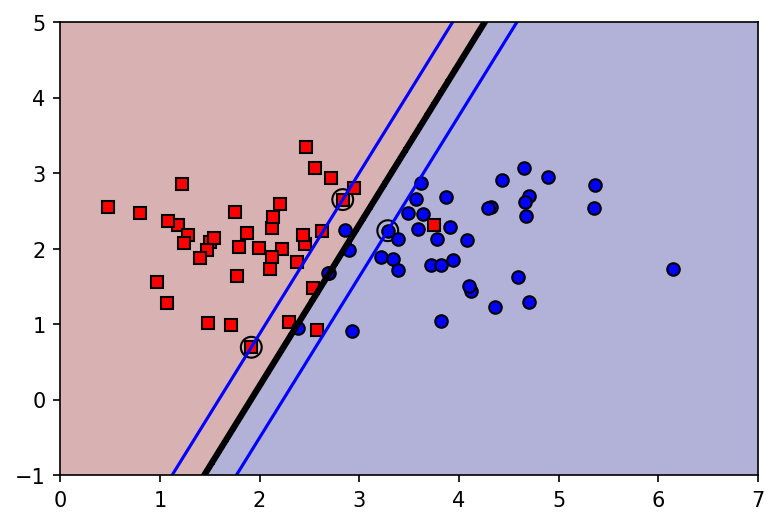

In [26]:
visualize(w1, b1, X, y, x_axis=[0, 7], y_axis=[-1, 5], dpi=150, support_vectors=M1)

# Soft margin SVM using Mini-batch Gradient Descent

## Problem on optimization without constraints

- Let's consider the first constraint: $1 - \xi_n -y_n(\mathbf{w}^T\mathbf{x} + b)) \leq 0 \Leftrightarrow \xi_n \geq 1 - y_n(\mathbf{w}^T\mathbf{x} + b))$ combined with the condition $\xi_n \geq 0$, so we get the equivalent problem: $~~~~~~\begin{eqnarray}
    (\mathbf{w}, b, \xi) &=& \arg \min_{\mathbf{w}, b, \xi} \frac{1}{2}{||\mathbf{w}||_2^2} + C \sum_{n=1}^N \xi_n  \ 
    , ~\text{sj to:}~ && \xi_n \geq \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x} + b)), ~\forall n = 1, 2, \dots, N~~~ (1)
\end{eqnarray}$ 

- We admit the following remark: 
-- If $(\mathbf{w}, b, \xi)$ is solution of $(1)$, that is, where the target function reaches its minimum value, then:
$~~~~~~~\xi_n = \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b)), ~\forall n = 1, 2, \dots, N ~~~ $

- Then, we rewrite $(1)$ as follows:
$~~~~\begin{eqnarray}
    (\mathbf{w}, b, \xi) &=& \arg \min_{\mathbf{w}, b, \xi} \frac{1}{2}{||\mathbf{w}||_2^2} + C \sum_{n=1}^N \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b)) \ 
    \text{subject to:}~ && \xi_n = \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b)), ~\forall n = 1, 2, \dots, N~~~
\end{eqnarray}$ 
 
- In a shorter form: 
$~~~~(\mathbf{w}, b)= \arg \min_{\mathbf{w}, b} \frac{1}{2}{||\mathbf{w}||_2^2} + C \sum_{n=1}^N \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b)) \triangleq \arg\min_{\mathbf{w}, b} J(\mathbf{w}, b) ~~~~$

## Loss function - Hinge loss
- Hinge loss: $J_n(\mathbf{w}, b) = \max(0, 1 - y_nz_n)$
- let's build loss function.
-- For each $(\mathbf{w}, b)$, call 
  $~~L_n(\mathbf{w}, b) = \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b))$
$⇒ L(\mathbf{w}, b) = \sum_{n=1}^N L_i = \sum_{n=1}^N \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b))$

- Applying weight decay: $J(\mathbf{w}, b) = \sum_{n=1}^N \max(0, 1 - y_n(\mathbf{w}^T\mathbf{x}_n + b)) + \frac{\lambda}{2} ||\mathbf{w}||_2^2$

- By extending x, make $\mathbf{x}_n \in \mathbb{R}^d$ to $\mathbf{x}_n \in \mathbb{R}^{d + 1}$. We get the loss function: $J(\mathbf{\bar{w}}) = \underbrace{\sum_{n=1}^N \max(0, 1 - y_n\bar{\mathbf{w}}^T\mathbf{\bar{x}}_n)}_{\text{hinge loss}} + \underbrace{\frac{\lambda}{2} ||\mathbf{w}||_2^2}_{\text{regularization}}$
- With hinge loss, considering each data point, we have two cases: 
-- Case 1: $\frac{d J(\mathbf{\bar{w}})}{d\mathbf{\bar{w}}} = 0$ if $~~1 - y_n \mathbf{\bar{w}}^T\mathbf{\bar{x}}_n \leq 0$
-- Case 2: $\frac{d J(\mathbf{\bar{w}})}{d\mathbf{\bar{w}}} = -y_n\mathbf{x}_n$ if $~~1 - y_n \mathbf{\bar{w}}^T\mathbf{\bar{x}}_n > 0$

- Then, we need to find $\mathcal{H} = \{n: u_n < 1\}$
$⇒ \nabla J(\mathbf{\bar{w}}) = \sum_{n \in \mathcal{H}} - y_n\mathbf{\bar{x}}_n  + \lambda 
\left[\begin{matrix}
\mathbf{w}\ 
0
\end{matrix}\right] ~~~$

- Finally, we have update rule of $\mathbf{\bar{w}}$:

$~~~~~~~~~~\mathbf{\bar{w}} = \mathbf{\bar{w}} - \eta \left(\sum_{n \in \mathcal{H}} - y_n\mathbf{\bar{x}}_n  + \lambda \left[\begin{matrix}
\mathbf{w}\ 
0
\end{matrix}\right]\right) ~~~$


In [29]:
def loss_function(w, t_Z, C):
  lamb = 1 / C
  u = w.T @ t_Z # [3, 1].T x [3, N] = [1, N]
  # should / n to avoid oveflow

  # g = -np.sum(Z, axis=1) + lamb * w
  hinge_loss = np.maximum(0, 1 - u)
  return np.sum(hinge_loss) + .5 * lamb * (w.T @ w - w[0, 0] * w[0, 0])

def grad(w, t_Z, C):
  lamb = 1 / C
  H = np.where(w.T @ t_Z < 1)[1]
  tZ = t_Z[:, H]
  g = -np.sum(tZ, axis=1, keepdims = True) + lamb * w
  g[0] -= lamb * w[0]
  return g 

In [42]:
def process(C, X, y, learning_rate, batch_size=10, epochs = 100):
  X0_bar = np.vstack((np.ones((1, X0.shape[0])), X0.T))
  X1_bar = np.vstack((np.ones((1, X1.shape[0])), X1.T))
  X_bar = np.vstack((np.ones((1, X.shape[1])), X))
  Z = X_bar * y # [3, 40]
  w = np.random.rand(Z.shape[0], 1)
  n_ = Z.shape[1]
  loss_epochs = []
  if n_ % batch_size != 0:
    raise ValueError("number of data points must be divisible by batch_size!")
  epochs += 1
  iter_per_epoch = n_ // batch_size
  for ep in range(epochs):
    mix_id = np.random.permutation(n_)
    g = np.random.rand(Z.shape[0], 1)
    for i in range(iter_per_epoch):
      id = range(i * batch_size, (i + 1) * batch_size)
      t_Z = Z[:, mix_id[id]]
      g = grad(w, t_Z, C)
      w -= learning_rate * g
      loss = loss_function(w, Z, C)[0, 0]

    loss_epochs.append(loss)

    if np.linalg.norm(g) < 1e-5:
      break

  return w, loss_epochs

w, loss_epochs = process(100, X, y, .02, 40, 30000)
w_hinge = w[1:].reshape(-1, 1)
b_hinge = w[0, 0]
print(w_hinge.T, b_hinge)

# [[-8.04969977  0.97179062]] 23.3227855949695
# [[-8.21175971  1.03963281]] 23.665193627318104

[[-3.63347289  1.41891414]] 7.66982439118216


[]

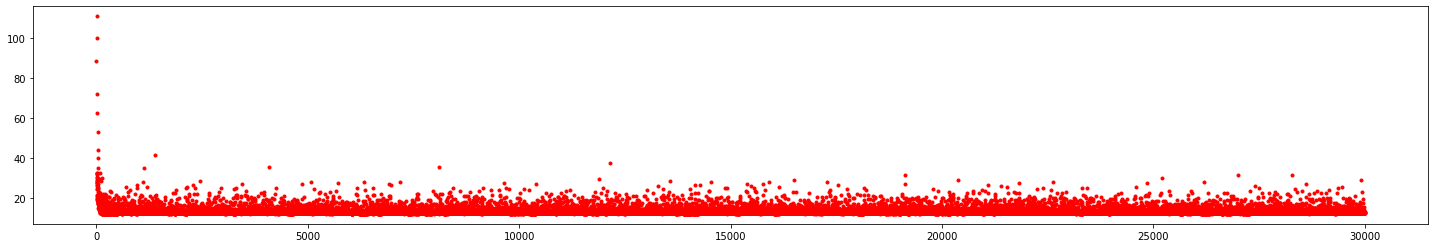

In [43]:
plt.figure(figsize=(25, 4))

index_X = list(range(len(loss_epochs)))
# print(index_X)

plt.plot(index_X, loss_epochs, 'r.')

plt.plot()

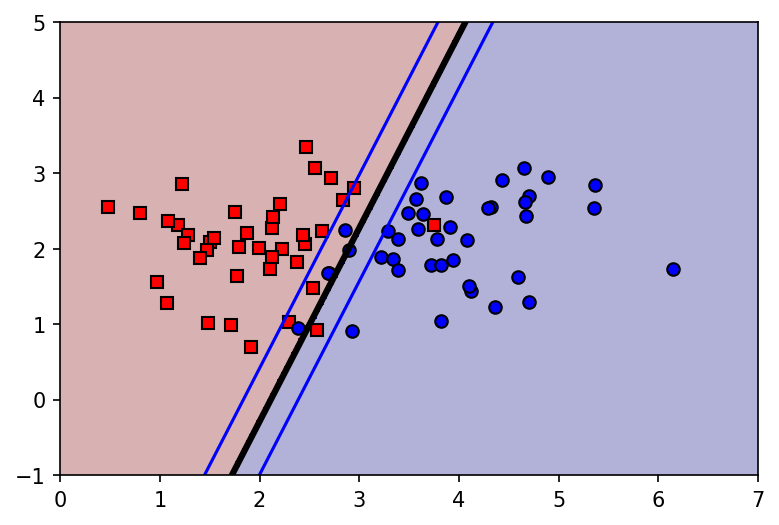

In [44]:
visualize(w_hinge, b_hinge, X, y, x_axis=[0, 7], y_axis=[-1, 5], dpi=150)

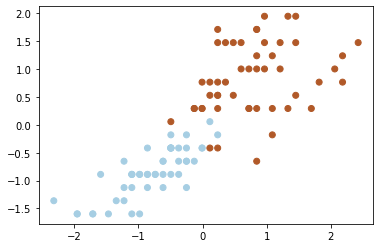

In [37]:
def load_data(cols):
  iris = sns.load_dataset("iris")
  iris = iris.tail(100)

  le = preprocessing.LabelEncoder()
  yt = le.fit_transform(iris["species"])

  Xt = iris.drop(["species"], axis=1)

  if len(cols) > 0:
    Xt = Xt[cols]

  return Xt.values, yt

cols = ["petal_length", "petal_width"]
X3, y3 = load_data(cols)

y3[y3 == 0] = -1
y3 = np.array([y3])
y3 = y3.astype(float)

# scale the data
scaler = StandardScaler()
X3 = scaler.fit_transform(X3)
X3 = X3.T

plt.scatter(X3[0], X3[1],c=y3, cmap=plt.cm.Paired)
plt.show()

     pcost       dcost       gap    pres   dres
 0:  6.1425e+02 -4.6522e+05  1e+06  4e-01  9e-14
 1:  4.0268e+03 -1.0227e+05  2e+05  6e-02  1e-13
 2:  2.0762e+03 -2.1056e+04  3e+04  7e-03  6e-14
 3: -4.5112e+02 -3.1258e+03  3e+03  4e-05  2e-14
 4: -7.2413e+02 -1.3650e+03  6e+02  9e-06  2e-14
 5: -7.5978e+02 -1.2535e+03  5e+02  5e-06  1e-14
 6: -1.0030e+03 -1.2401e+03  2e+02  7e-07  2e-14
 7: -1.0483e+03 -1.0556e+03  7e+00  2e-08  3e-14
 8: -1.0511e+03 -1.0512e+03  8e-02  2e-10  3e-14
 9: -1.0511e+03 -1.0511e+03  8e-04  2e-12  3e-14
Optimal solution found.
lambda = 
[[2.49043725e-06 1.74400943e-06 8.14898156e+01 6.44550717e-07
  3.73388609e-06 9.45316082e-07 6.81342403e+01 2.81329347e-07
  1.10499069e-06 7.02898207e-07 3.02856180e-07 8.13955617e-07
  4.01626738e-07 2.49043725e-06 4.94906745e-07 9.67513874e-07
  1.74400943e-06 4.29054439e-07 1.74400943e-06 4.33417335e-07
  9.99999980e+01 6.44550717e-07 8.14898156e+01 1.01641113e-06
  7.79200559e-07 9.67513874e-07 4.98110284e-06 9.9999998

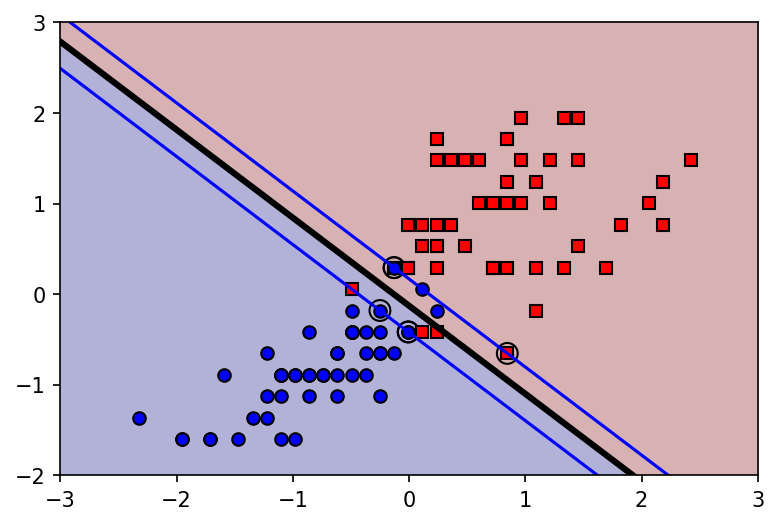

In [38]:
l2, w2, b2, M2 = softmargin_svm(100, X3, y3, show_progress=True)
print('lambda = ')
print(l2.T)

visualize(w2, b2, X3, y3, x_axis=[-3, 3], y_axis=[-2, 3], dpi=150, support_vectors=M2)

[[3.06644034 2.85851103]] 0.29014282204968683


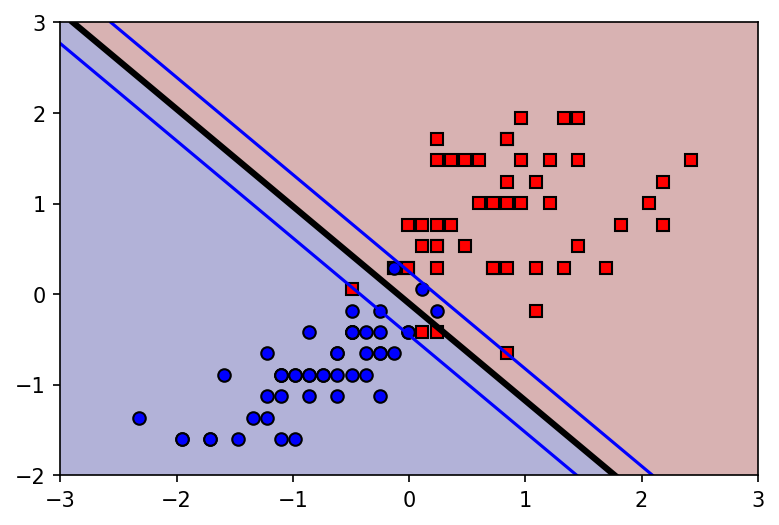

In [46]:
w3, loss_epochs3 = process(100, X3, y3, .02, 20, 30000)
w_3 = w3[1:].reshape(-1, 1)
b_3 = w3[0, 0]
print(w_3.T, b_3)

visualize(w_3, b_3, X3, y3, x_axis=[-3, 3], y_axis=[-2, 3], dpi=150)